In [1]:
from keras.optimizers import Adadelta
from keras.models import load_model
import os
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import backend as K
import h5py

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'utils/')
from deep_models import *
from utils_challenge import *
from utils_projections import *
from np_ioueval import iouEval

Using TensorFlow backend.


Files in input_data/normalized_data are spherical projections of point clouds. Ground was already detected using quasi flat zones algorithm from BEV projections [1]

In [2]:
sequence = 'train/'
file_name = '40.h5' # [we uploaded: 00,10,20,30,40 point clouds without GROUND for testing pourposes]

In [3]:
path_to_normalized_data = 'input_data/normalized_data/' + sequence
path_to_frozen_model = 'input_data/frozen_model/'
model_name = 'model.hdf5'
output_path = 'output_data/2d_preds/'

print("loading features from:", path_to_normalized_data)
print("loading model from:", path_to_frozen_model)

loading features from: input_data/normalized_data/train/
loading model from: input_data/frozen_model/


In [4]:
model = load_model(path_to_frozen_model + model_name,compile= False)

In [5]:
features = load_h5_file(path_to_normalized_data + file_name)
feature_names = ['z', 'depth', 'nx', 'ny', 'nz']

In [6]:
# Most of the ground was already classified using LFZ

In [7]:
X_to_pred = load_features_spherical(path_to_normalized_data, file_name, channels=[2,3,4,5,6])
print(X_to_pred.shape)

z_channel = X_to_pred[0,feature_names.index('z'),:,:]
depth_channel = X_to_pred[0,feature_names.index('depth'),:,:]
nx_channel = X_to_pred[0,feature_names.index('nx'),:,:]
ny_channel = X_to_pred[0,feature_names.index('ny'),:,:]
nz_channel = X_to_pred[0,feature_names.index('nz'),:,:]

(1, 5, 64, 1024)


Visualize each channel of input image

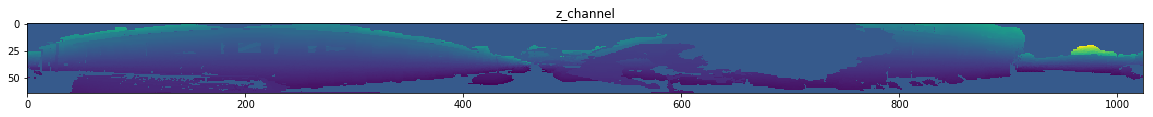

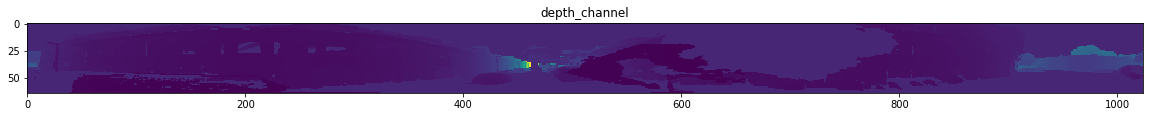

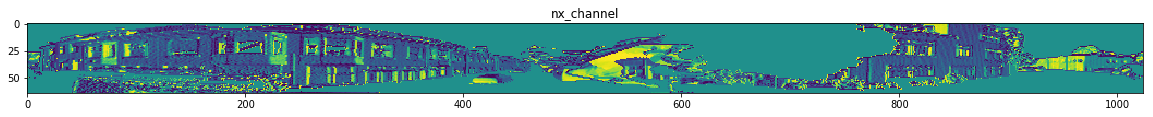

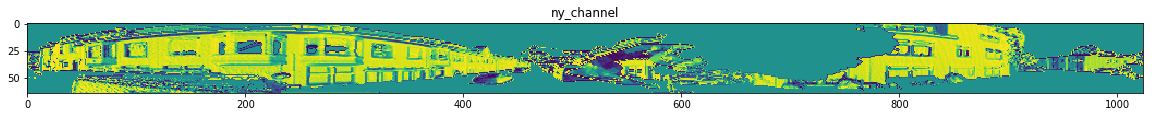

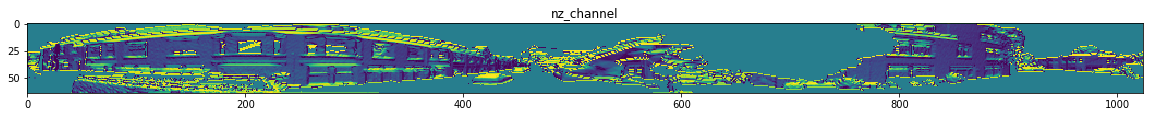

In [8]:
plt.figure(figsize=(20,10))
plt.title("z_channel")
plt.imshow(z_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("depth_channel")
plt.imshow(depth_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("nx_channel")
plt.imshow(nx_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("ny_channel")
plt.imshow(ny_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("nz_channel")
plt.imshow(nz_channel)
plt.show()

We called "empty pixels" to every pixel in the spherical projection without points from 3D point cloud. We find them from X_pred using normal channels.

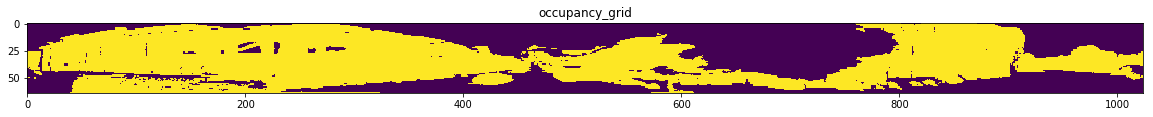

In [9]:
empty_pixels = np.where( (nx_channel == 0) & (ny_channel == 0) & (nz_channel == 0))
occupancy_grid = np.ones_like(nx_channel)
occupancy_grid[empty_pixels] = 0

plt.figure(figsize=(20,10))
plt.title("occupancy_grid")
plt.imshow(occupancy_grid)
plt.show()

In [10]:
color_map = {
    -1: [0, 0, 0],    # empty -> black
    0: [0, 0, 0],     # undefined -> black
    1: [255, 0, 0],   # building -> red
    2: [255, 255, 0], # car -> yellow
    3: [0, 0, 255],   # ground -> blue
    4: [0, 255, 255], # pole -> cyan
    5: [0, 255, 0]    # vegetation -> green
}

In [11]:
y_pred = model.predict(X_to_pred)
y_pred = np.argmax(y_pred,axis=1)+1
y_pred = y_pred[0,:,:]

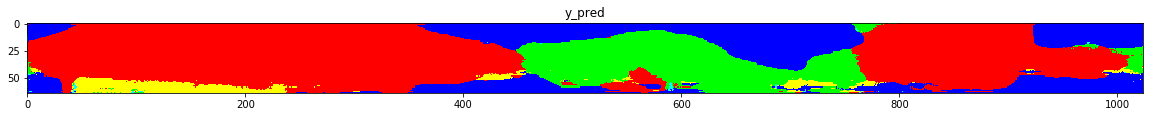

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(map_gt_to_colored(y_pred, color_map))
plt.title("y_pred")
plt.show()

In [13]:
y_pred = y_pred * occupancy_grid

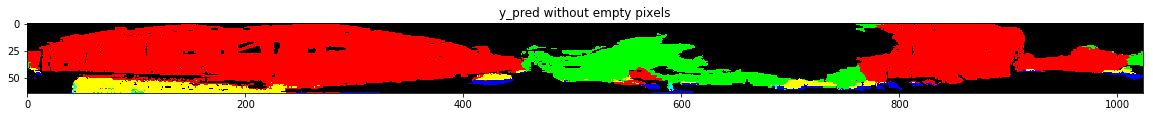

In [14]:
y_pred[empty_pixels] = 0
plt.figure(figsize=(20,10))
plt.imshow(map_gt_to_colored(y_pred, color_map))
plt.title("y_pred without empty pixels")
plt.show()

In [15]:
save_h5_file(y_pred, output_path + file_name)
print("2D prediction saved: ", output_path + file_name)

2D prediction saved:  output_data/2d_preds/40.h5


## References
[1]  Hernandez,  J, Marcotegui,  B.  Point cloud segmentation towards urban ground modeling.   In:  2009 Joint Urban Remote Sensing Event. IEEE;2009, p. 1–5